In this course project, we are going to compare two optimization techniques - gradient descent and Newton's method . We will conduct experiment to see whether they are sensitive to feature scaling, and which method is better if the objective function is guarenteed to be convex. Because we are concentrating on optimization techniques instead of selecting and comparing regression models, we are going to build a very simple linear regression model without any feature transformation (not normalization).

In [99]:
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler

# Data Preparation

The dataset used in this project is the house price data of King county in Seattle. First we will have a look at the dataset: how many features? how many samples? Is there any missing data? Do we use all the features, or just a small proportion of them?

In [100]:
# load data
house = pd.read_csv("kc_house_data.csv", nrows=500)
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [101]:
# examine missing values
print(house.isnull().any())
# inspect type
print(house.dtypes)
# drop the id and date columns
house = house.drop(['id', 'date'],axis=1)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_

The data is pretty clean. There is no missing values. The output is the house price and there are 18 features in total (the data and id columns are dropped because they have nothing to do with house price). Now we pairplot the features and output to roughly examine the correlations between the features and the predictor.

<IPython.core.display.Javascript object>


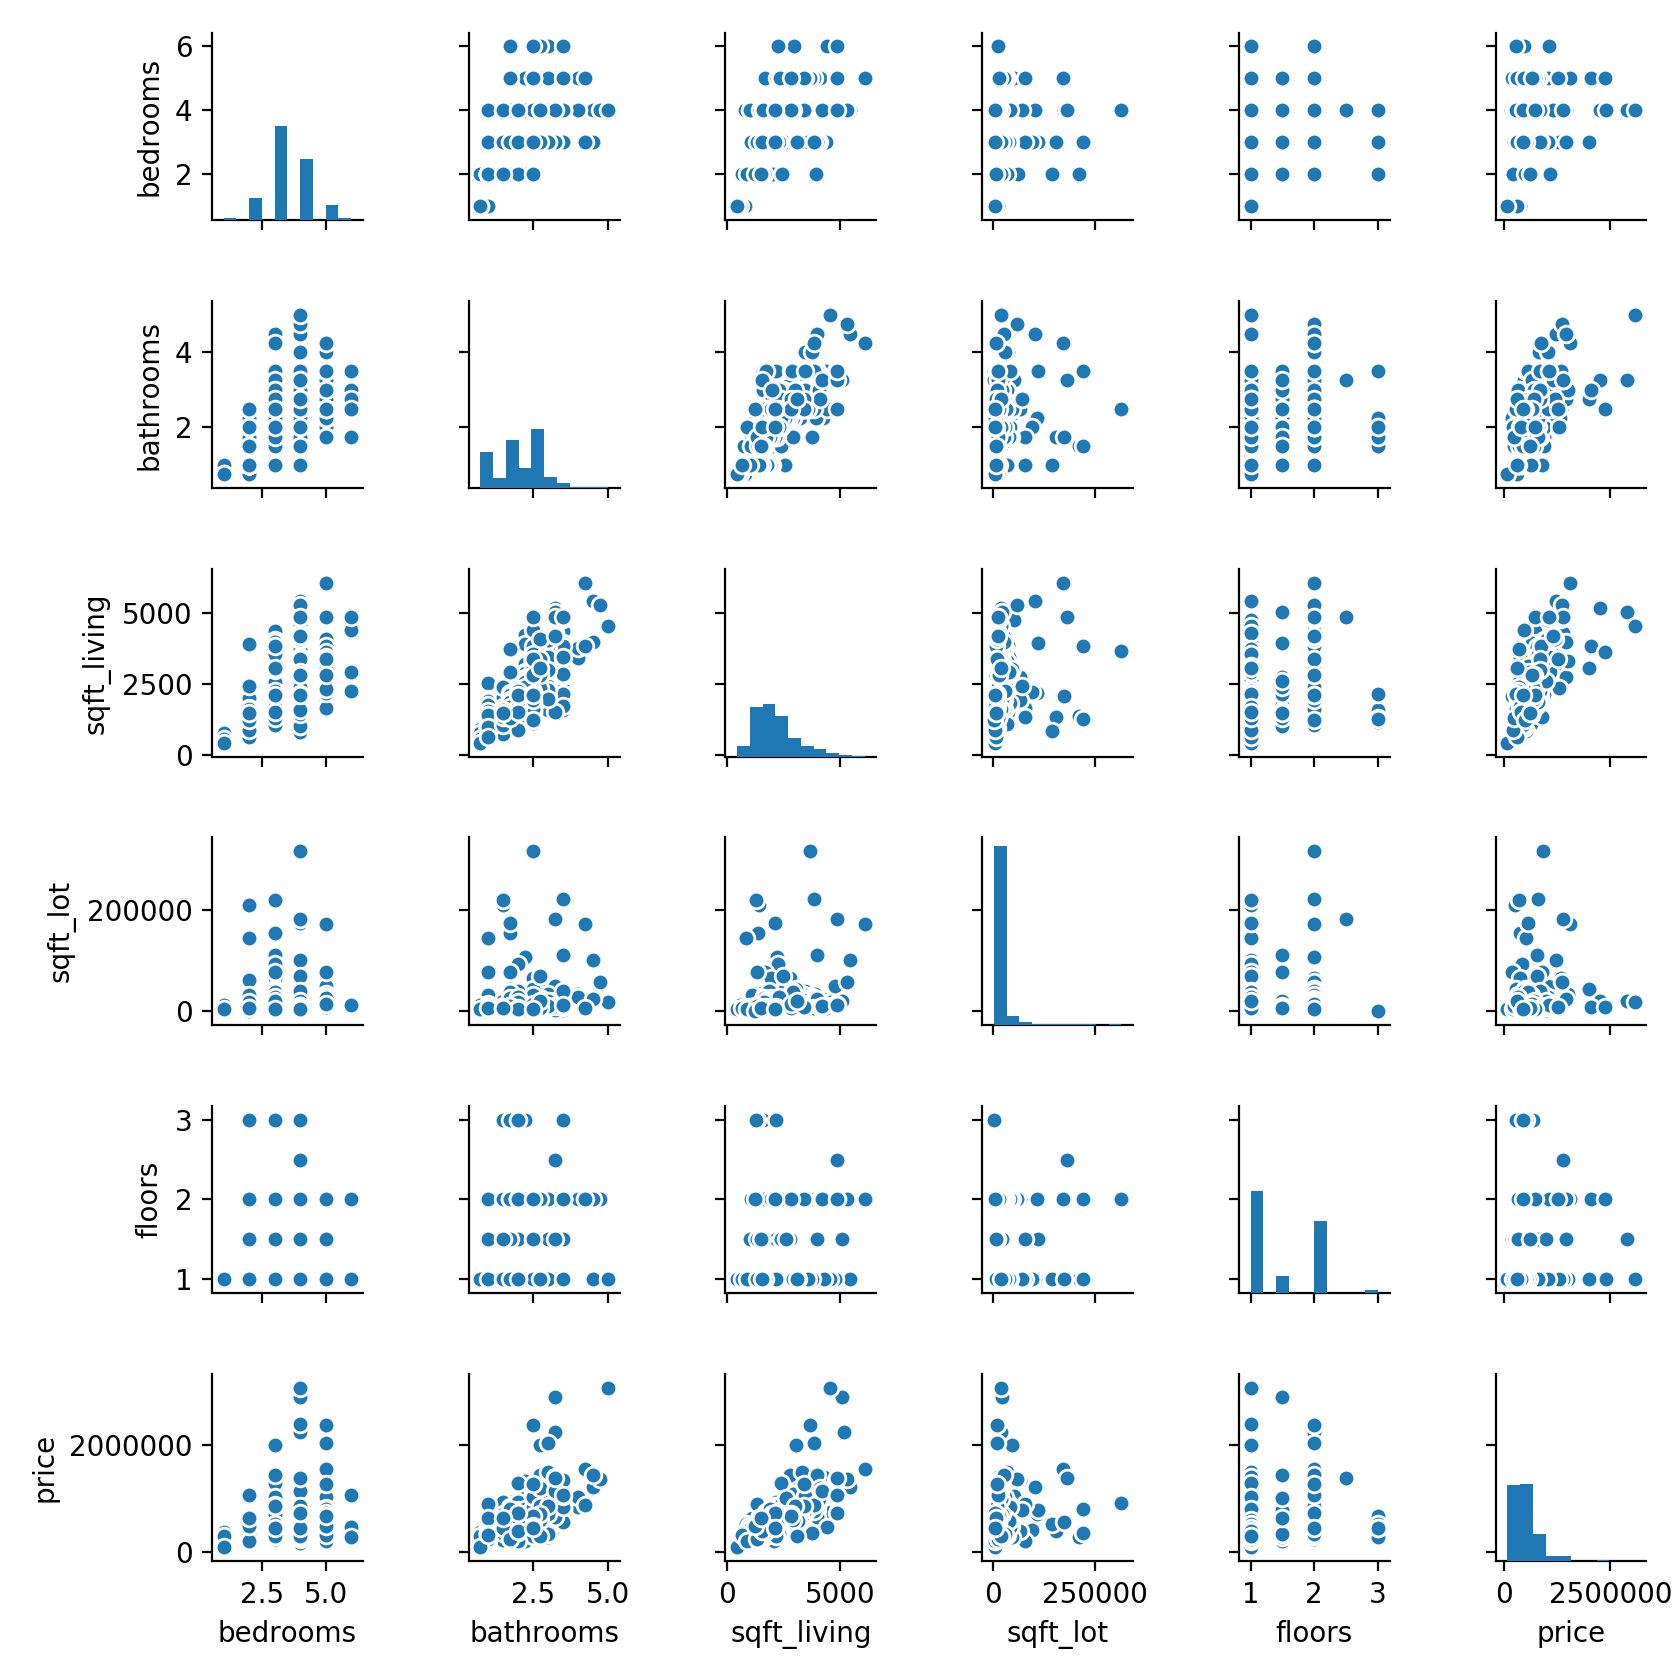

In [102]:
sns.pairplot(house[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','price']], size=1.4)

<IPython.core.display.Javascript object>


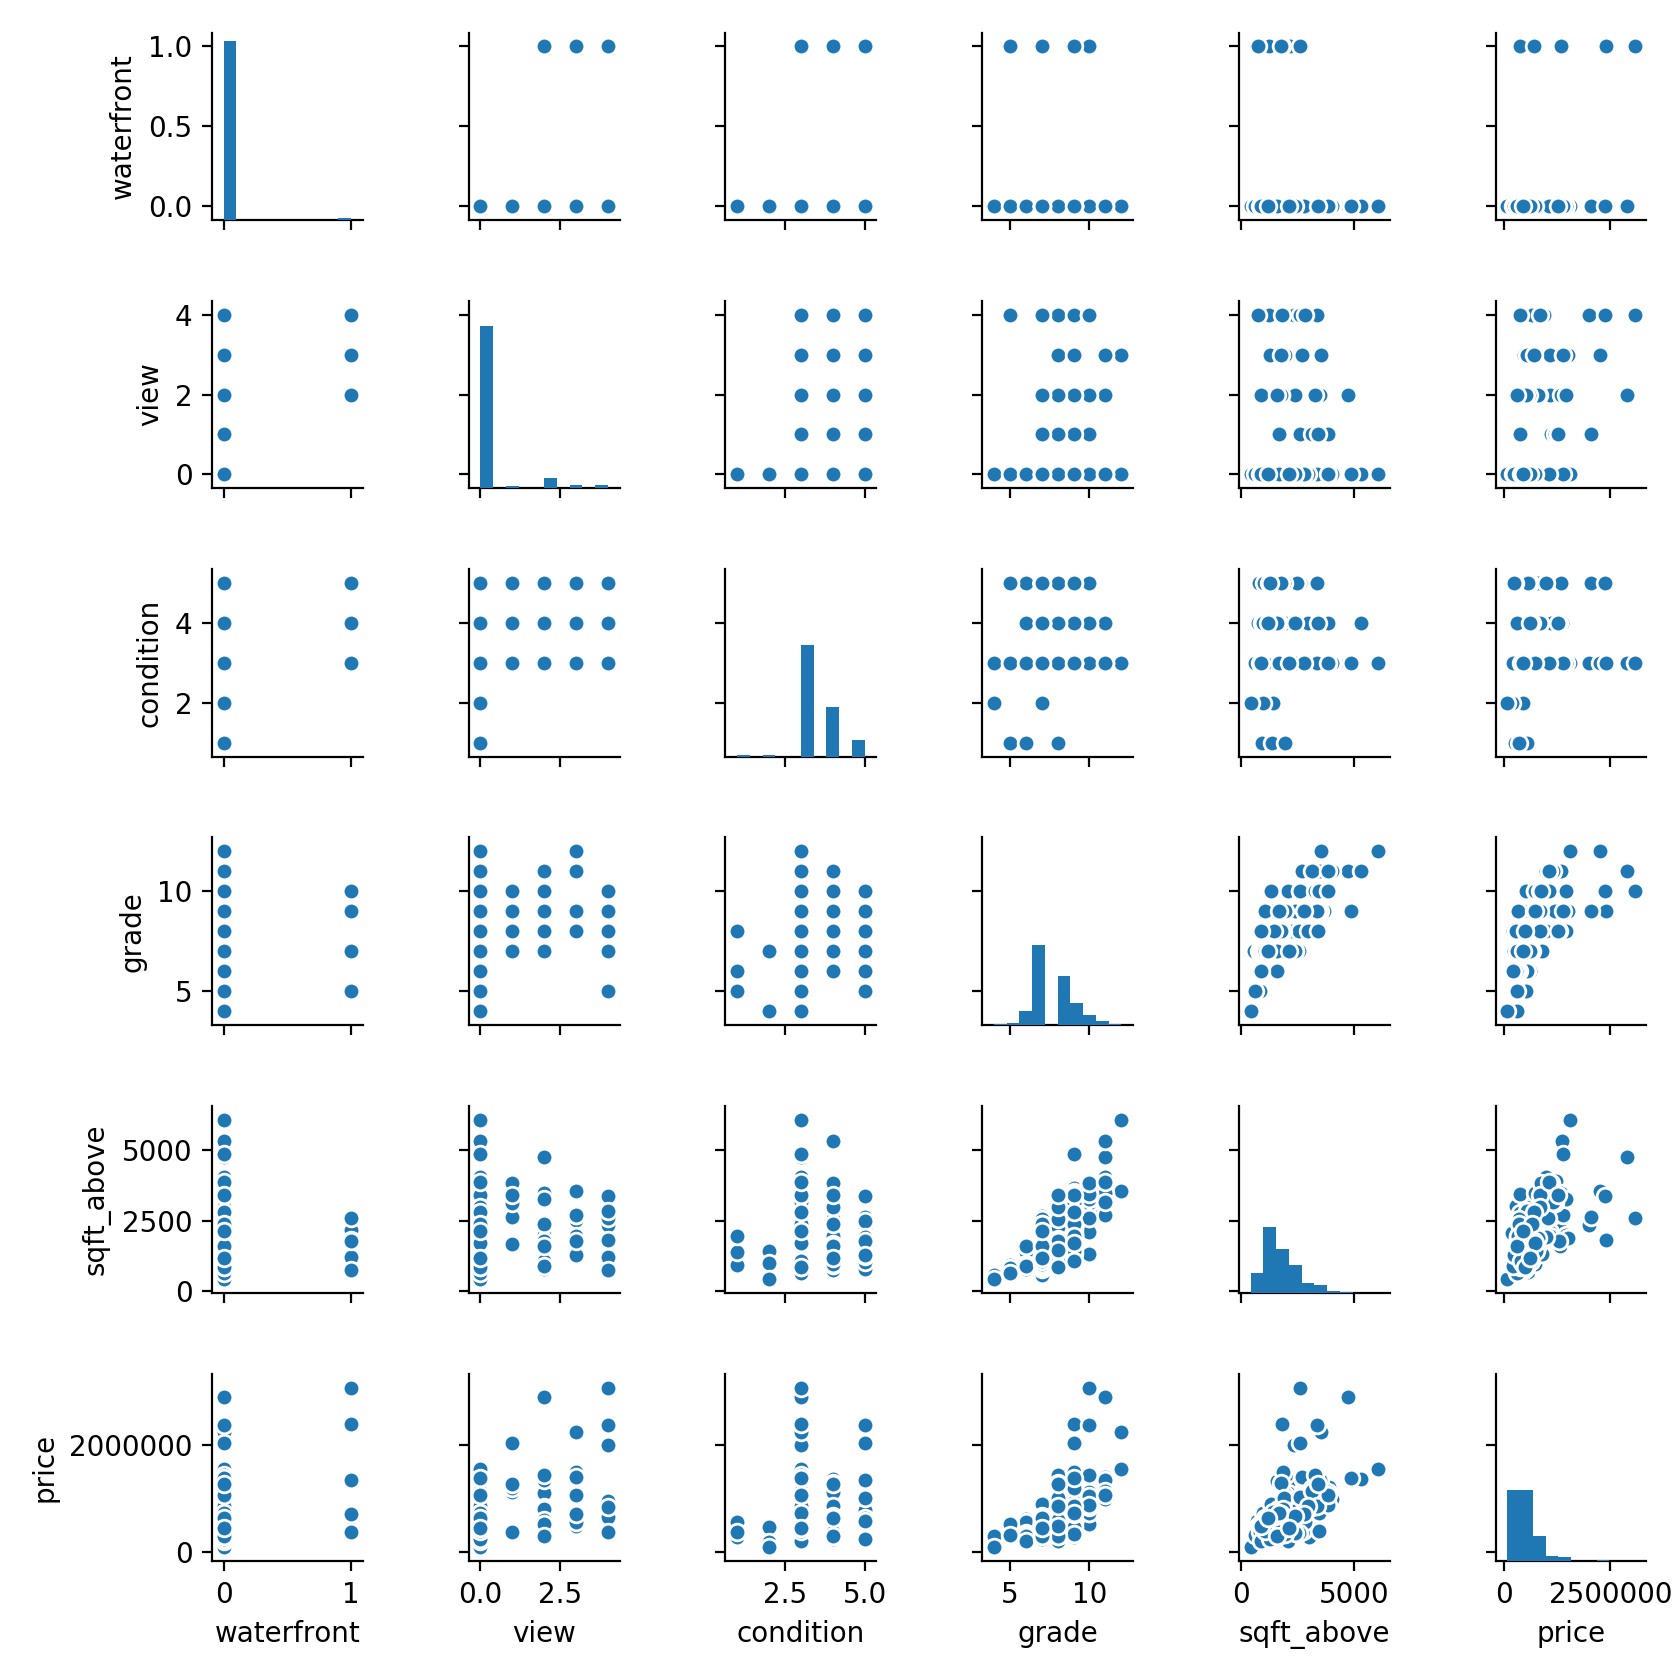

In [103]:
sns.pairplot(house[['waterfront', 'view', 'condition',  'grade', 'sqft_above', 'price']], size=1.4)

<IPython.core.display.Javascript object>


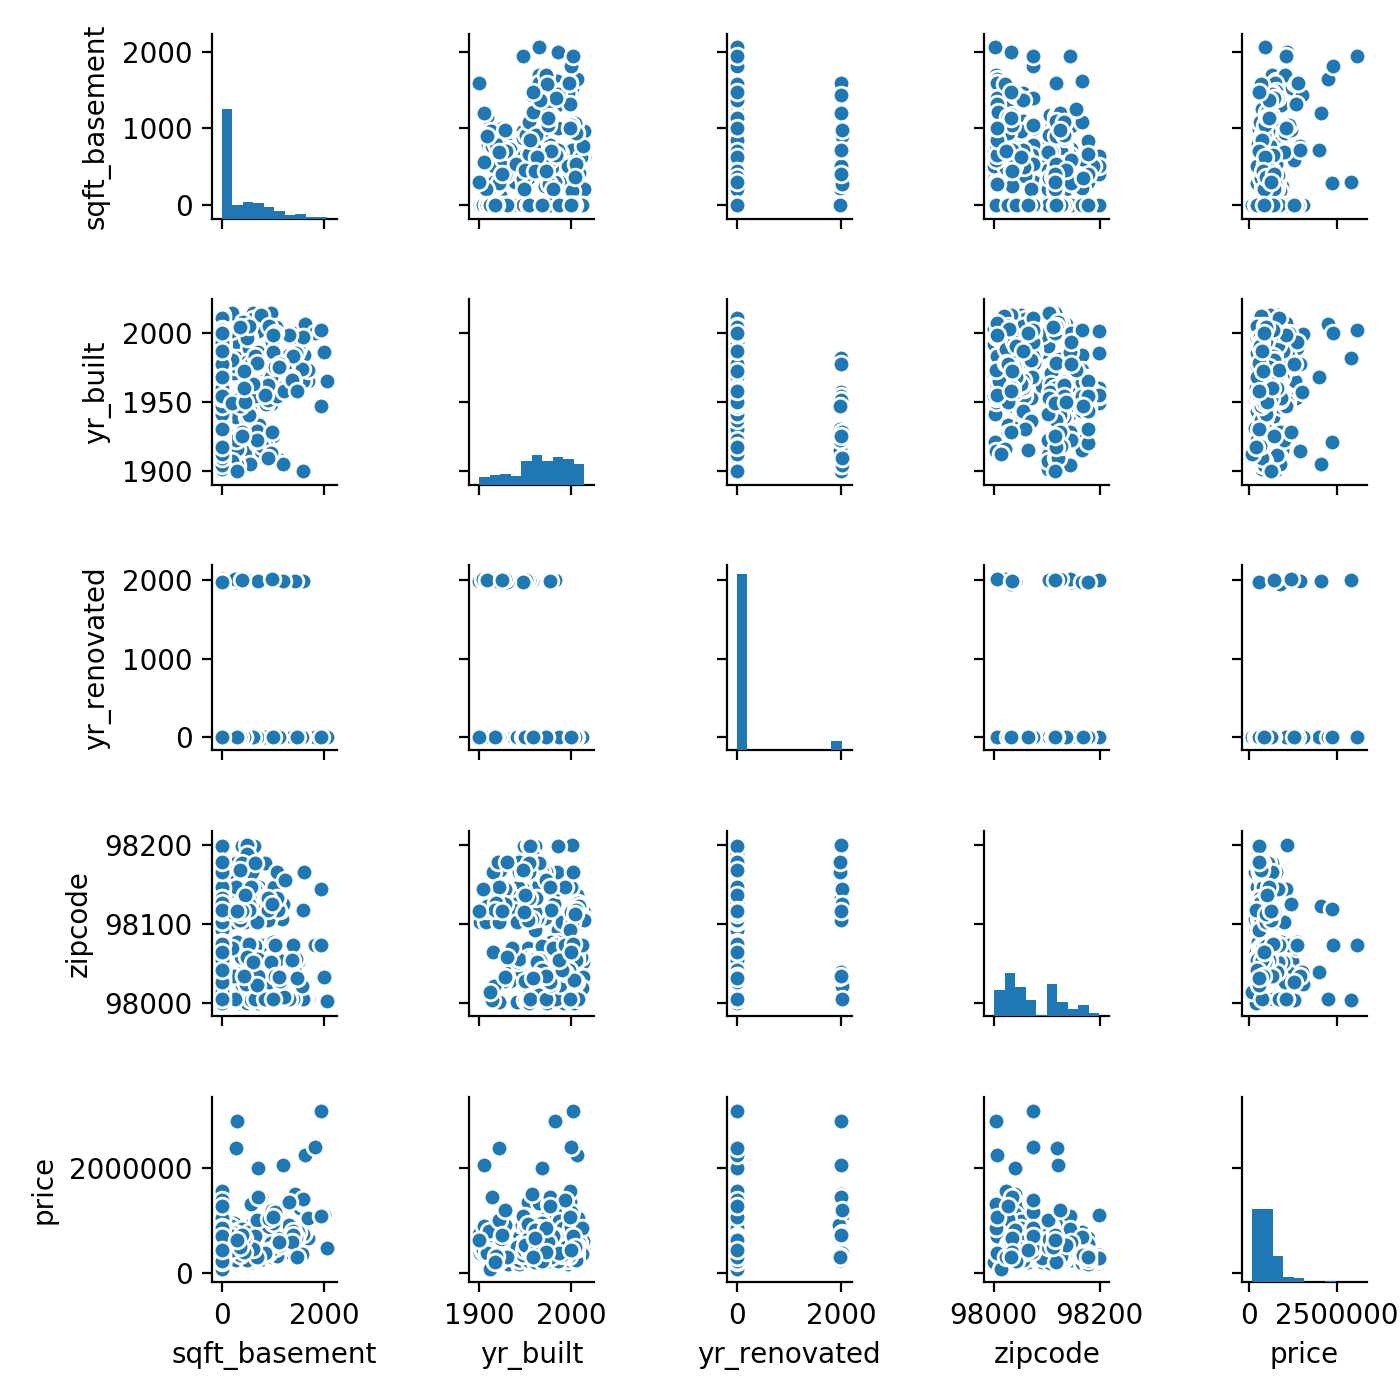

In [104]:
sns.pairplot(house[['sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'price']], size=1.4)

<IPython.core.display.Javascript object>


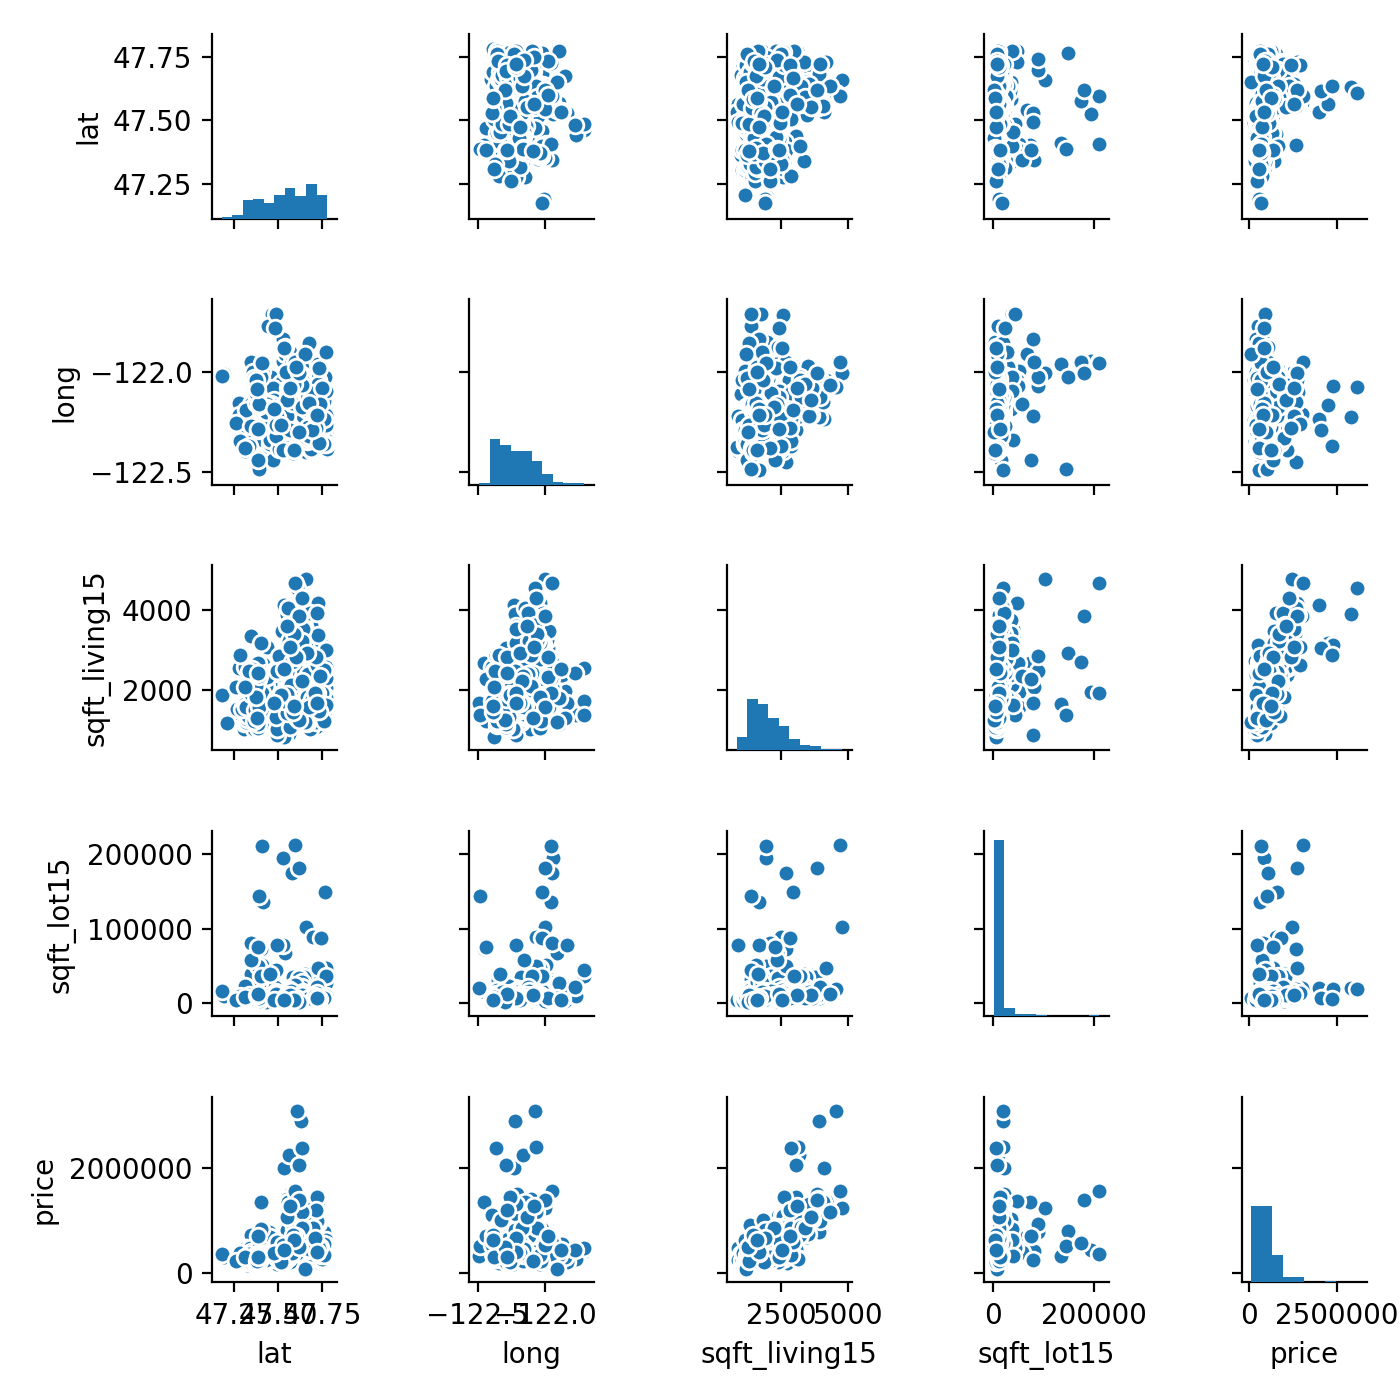

In [105]:
sns.pairplot(house[['lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']], size=1.4)

Based on the pairplots, we pick 5 features as the input features: bedrooms, sqft_living, grade, sqft_above, sqft_living15, because they show a classic linear correlation with the target output - price. In the following python cells, we examine the numerical range of each input feature.

In [106]:
# extract features and predictor that we are going to use
house_data = house[['bedrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'price']].values
X = house_data[:, :-1]
Y = house_data[:, -1:]

In [107]:
# plot the distributions of input features
def feature_distributions(x, y, title):
    # create figure 
    fig, ax = plt.subplots(1, 1, figsize=(6,3))

    # loop over input and plot each individual input dimension value
    N = np.shape(x)[1]    # dimension of input
    for n in range(N):
        ax.scatter((n+1)*np.ones((len(y),1)),x[:,n],color = 'k',edgecolor = 'w')

    # set xtick labels 
    ticks = np.arange(1,N+1)
    labels = [r'$x_' + str(n+1) + '$' for n in range(N)]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, minor=False)

    # label axes and title of plot, then show
    ax.set_xlabel('feature')
    ax.set_ylabel(r'$\mathrm{value}$',rotation = 0,labelpad = 20)
    ax.set_title(title)
    plt.show()

<IPython.core.display.Javascript object>


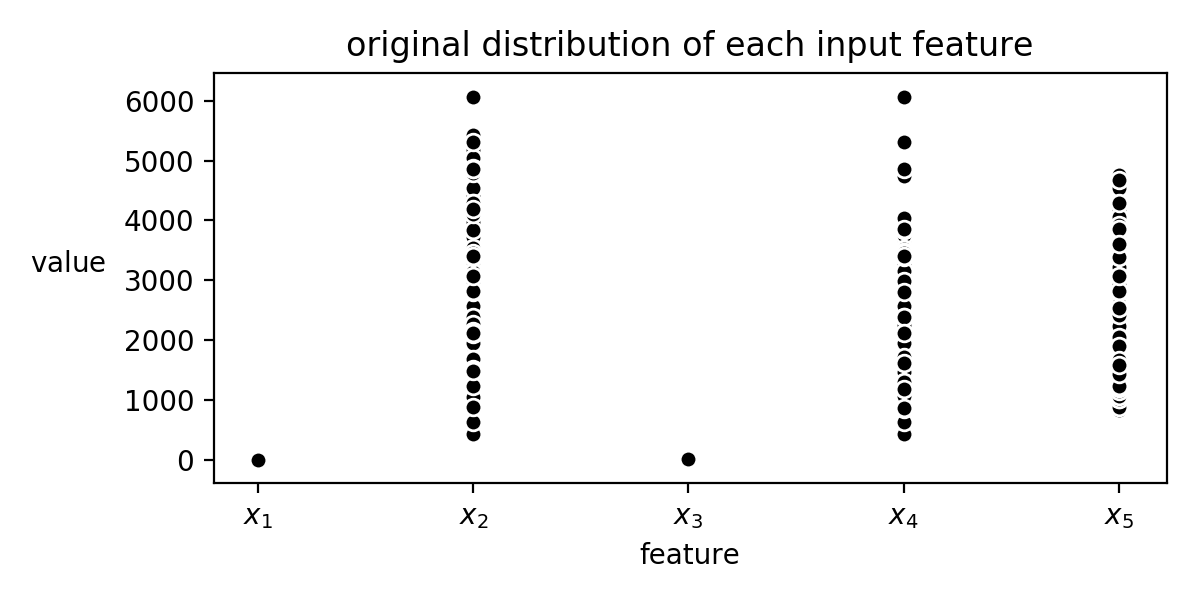

In [108]:
feature_distributions(X, Y, 'original distribution of each input feature')

As we can see in the plot above, the distributions of original input features are way out of scale with each other, therefore the gradient descent are expected to be very slow. The normalization step is a must for gradient descent algorithm (we will still run gradient descent on unnormalized features to testify our expectation). In addition, we also normalize the output, otherwise the cost will explode.

In [109]:
# inplace input features and output scaling
scaler = MaxAbsScaler()
normed_X = scaler.fit_transform(X)
normed_Y = scaler.fit_transform(Y)

<IPython.core.display.Javascript object>


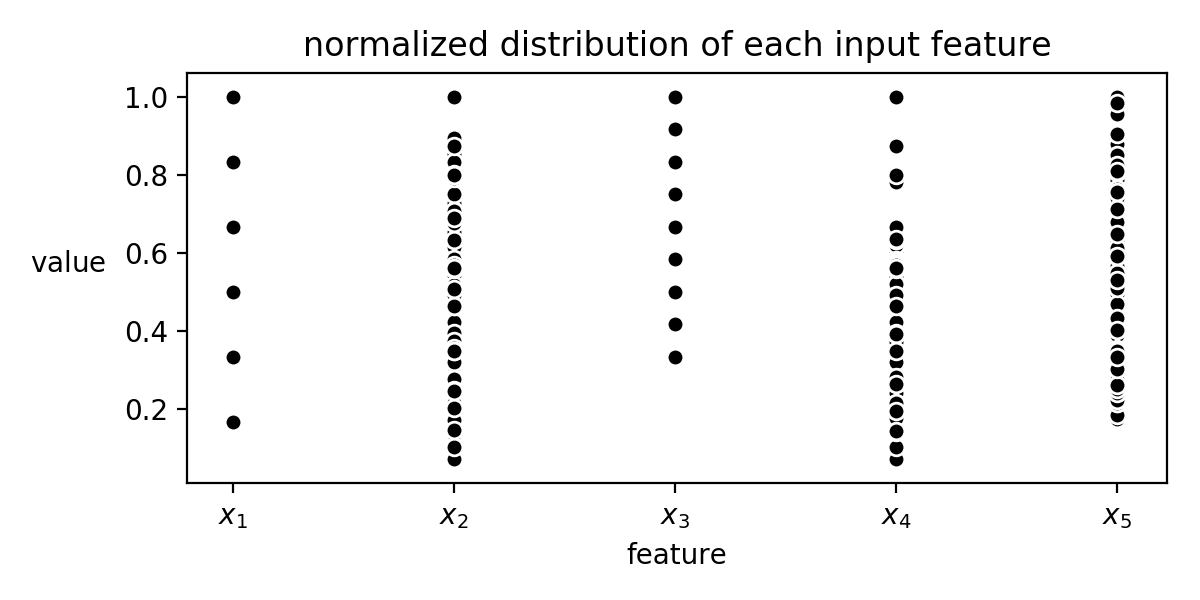

In [110]:
# visualize the normalized input features
feature_distributions(normed_X, normed_Y, 'normalized distribution of each input feature')

# Experiments

In this step, we will optimize the least squares cost function using gradient descent and Newton's method.

In [111]:
# prediction function
def predict(x, w):
    return w[0] + np.dot(x, w[1:])

In [112]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    # w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

In [113]:
# import autograd functionality
from autograd import grad
from autograd import hessian

# run newton's method - input: function ('g'), initial point ('w'), maximum number of iterations ('max_its')
def newtons_method(g,w_init,max_its,epsilon):
    # check that initial point is float (for autograd)
    if np.size(w_init) == 1:
        w = np.asarray(float(w_init))
    else:
        w = np.asarray([float(s) for s in w_init])
        w.shape = np.shape(w_init)
        
    # Compute gradient and Hessian functions for input function
    g_grad = grad(g)              # gradient of input function
    g_hess = hessian(g)           # hessian of input function
    
    # Newton's loop
    weight_history = []           
    for k in range(max_its):
        # evluate current point with gradient and hessian
        grad_eval = g_grad(w)
        hess_eval = g_hess(w)

        # solve linear system for weights: setup system Aw = b, make sure A is correct shape (for use of np.linalg)
        A = hess_eval
        A.shape = (int((np.size(A))**(0.5)),int((np.size(A))**(0.5)))
        
        # add epsilon weighted diagonal to avoid any problems at flat regions
        A += epsilon*np.eye(np.size(w))
        
        # form b - our system: Aw = b
        b = np.dot(A,w) - grad_eval
        
        # solve for w
        w = np.linalg.solve(A,b)

        # record weight in history
        weight_history.append(w)
    return weight_history

First we experiment with the gradient descent optimizer. Here unnormalized input features and normalized output are used. 

In [114]:
## optimize least_squares using gradient descent with normalized input features and output
# least squares cost
least_squares = lambda w : np.sum((predict(X, w) - normed_Y)**2)

# initialize weights
w_init = np.random.randn(normed_X.shape[1] + 1, 1) * 0.1

# run gradient descent
max_iters = 5000
alpha = 10**-4
w_history = gradient_descent(least_squares, w_init,alpha, max_iters, beta=0.5, version='normalized')
iters = range(max_iters)
costs = [least_squares(w) for w in w_history]

last 50 costs:
[30.89482380791155, 16.32990838138339, 100.29804385683315, 51.031023007930443, 30.895194505116997, 16.329750240116915, 100.29629947877579, 51.029807463790064, 30.895565066054534, 16.329592115402669, 100.29455557553922, 51.028592241654557, 30.895935490821106, 16.329434007232294, 100.29281214679955, 51.027377341305339, 30.89630577951344, 16.329275915597428, 100.29106919223328, 51.026162762523988, 30.896675932228217, 16.329117840489744, 100.28932671151728, 51.024948505092354, 30.897045949061972, 16.328959781900899, 100.28758470432868, 51.023734568792548, 30.897415830111182, 16.328801739822563, 100.28584317034516, 51.022520953406875, 30.897785575472156, 16.328643714246425, 100.2841021092445, 51.021307658717888, 30.898155185241198, 16.328485705164177, 100.28236152070504, 51.020094684508422, 30.898524659514347, 16.3283277125675, 100.28062140440542, 51.018882030561528, 30.898893998387639, 16.328169736448103, 100.27888176002466, 51.017669696660505, 30.899263201956988, 16.3280117

<IPython.core.display.Javascript object>


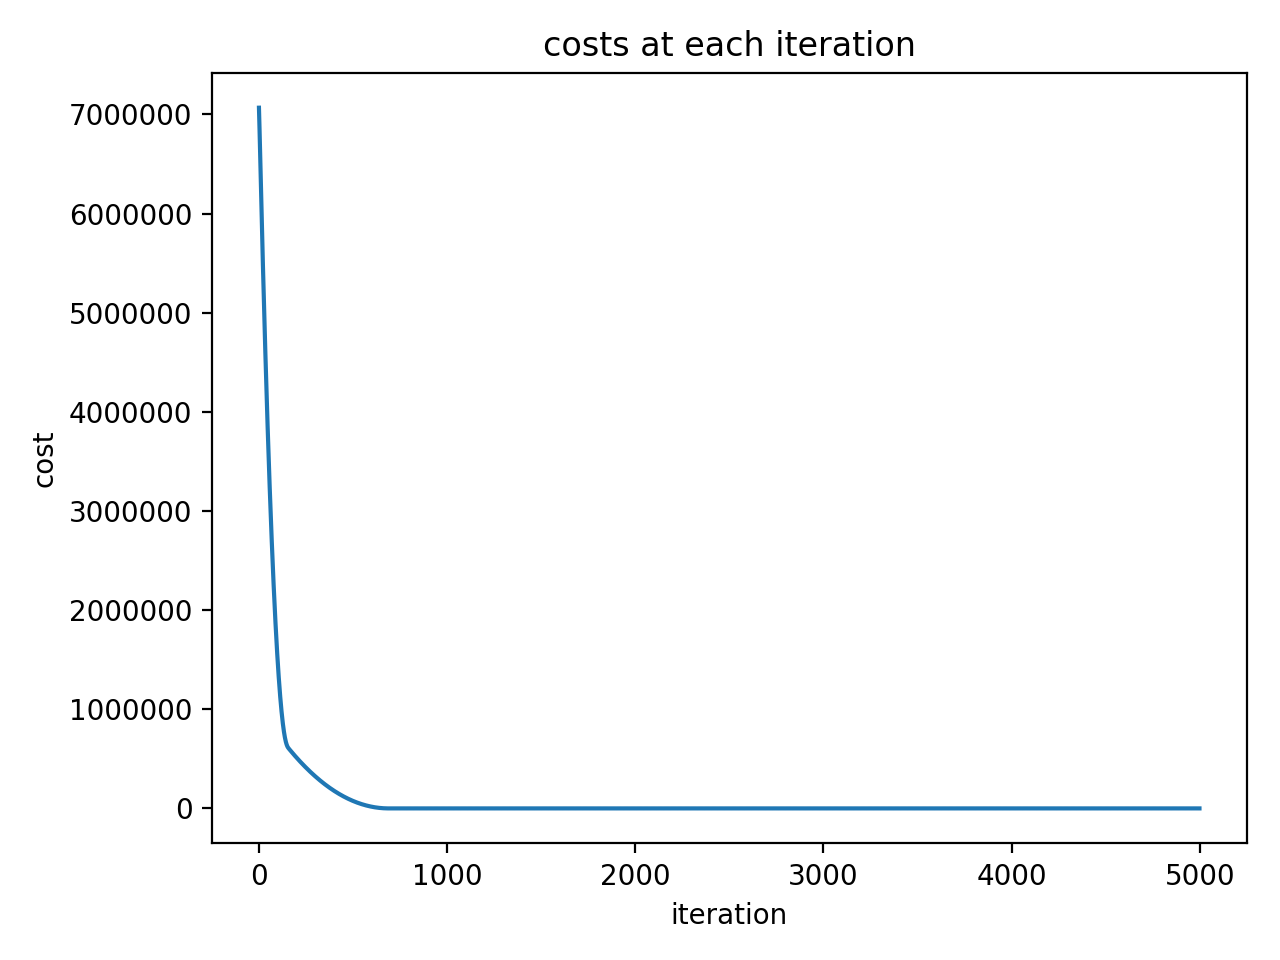

In [115]:
# shows the cost at each iteration
print('last 50 costs:')
print(costs[-50:])
fig = plt.figure()
plt.plot(iters, costs)
plt.title('costs at each iteration')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

The cost function seems to converge, but based on the costs history printed above the figure, the cost is still getting smaller, which means the cost function does not converge in 5000 iterations. Actually, if the input features are unnormalized, the gradient descent will not work at all.

Next we try gradient descent with normalized input features.

In [116]:
## optimize least_squares using gradient descent with normalized input features and output
# least squares cost
least_squares = lambda w : np.sum((predict(normed_X, w) - normed_Y)**2)

# initialize weights
w_init = np.random.randn(normed_X.shape[1] + 1, 1) * 0.1

# run gradient descent
max_iters = 1000
alpha = 10**-3
w_history = gradient_descent(least_squares, w_init,alpha, max_iters, beta=0.5, version='normalized')
iters = range(max_iters)
costs = [least_squares(w) for w in w_history]

The cost function basically converges after about 500 iterations. 

<IPython.core.display.Javascript object>


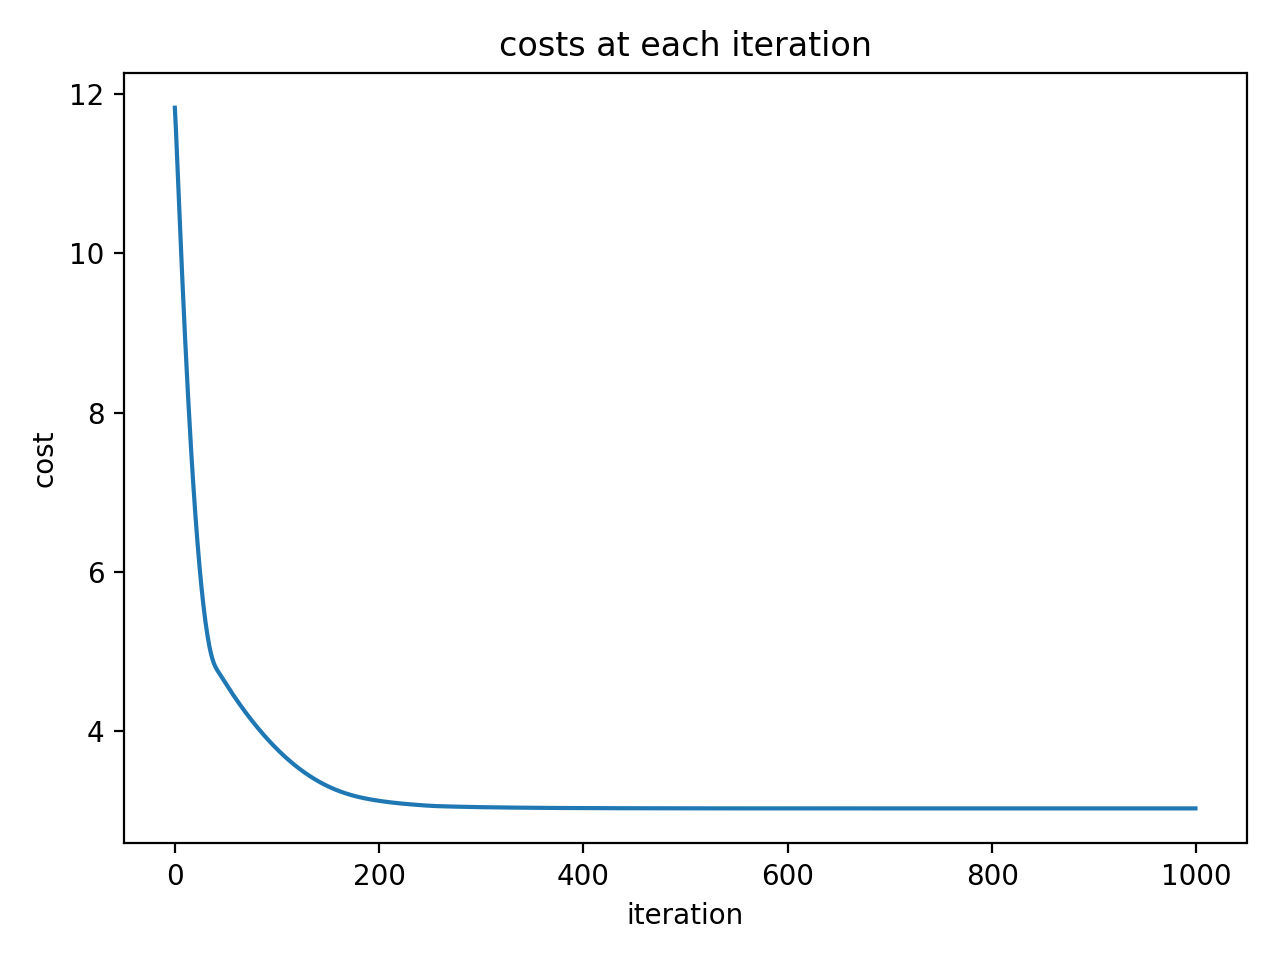

In [117]:
# plot the cost at each iteration
fig = plt.figure()
plt.plot(iters, costs)
plt.title('costs at each iteration')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

We then optimize the regressor using Newton's method with unnormalized and normalized input features. The cost function converges in less than 5 and 10 steps respectively.

<IPython.core.display.Javascript object>


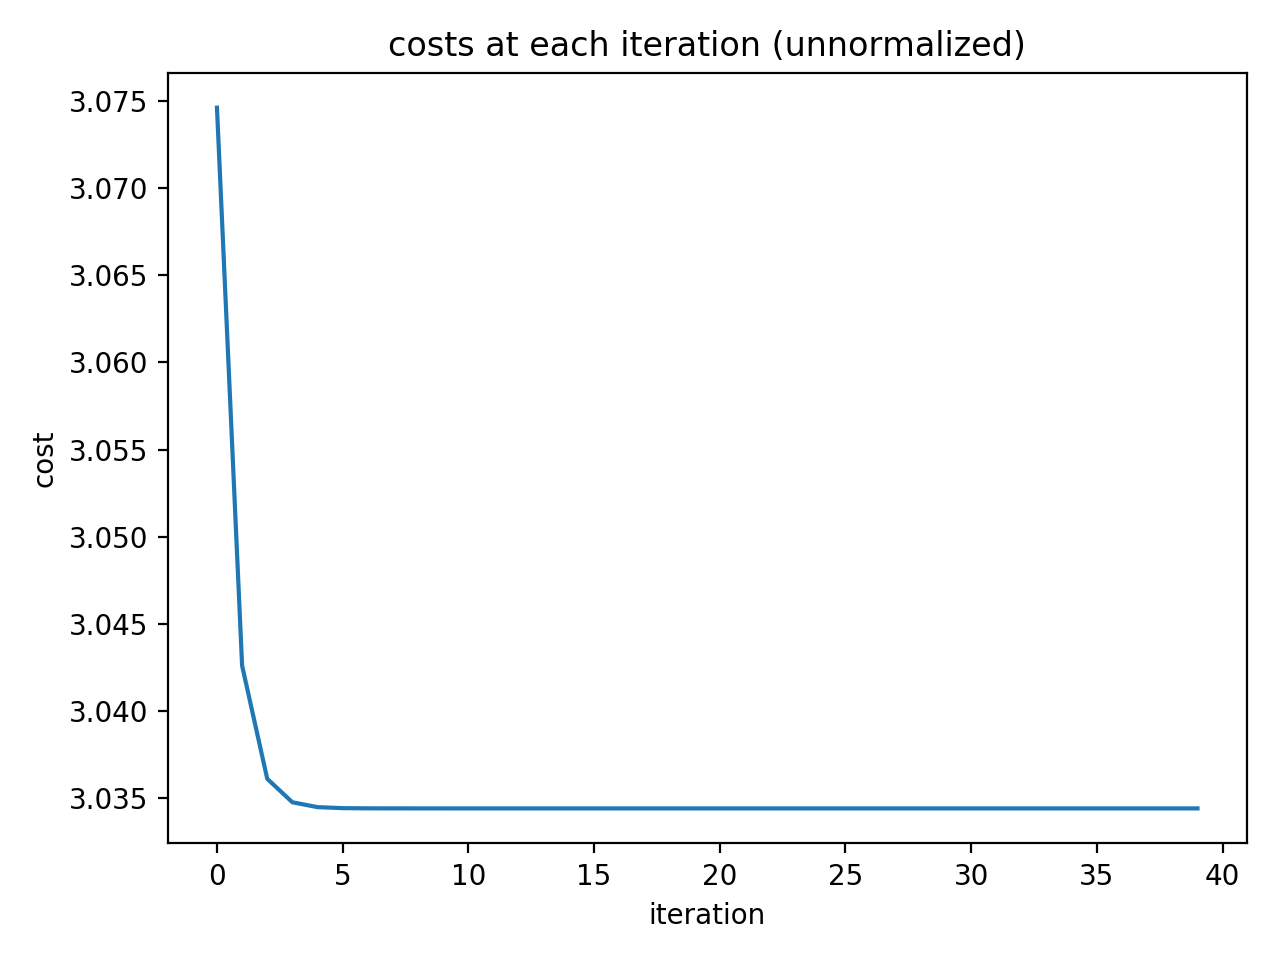

In [118]:
epsilon= 10**1
max_its=40
least_squares = lambda w: np.sum((predict(X, w) - normed_Y)**2)
w_history = newtons_method(least_squares,w_init,max_its, epsilon)
iters = range(max_its)
costs = [least_squares(w) for w in w_history]
fig2 = plt.figure()
plt.plot(iters, costs)
plt.title('costs at each iteration (unnormalized)')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

<IPython.core.display.Javascript object>


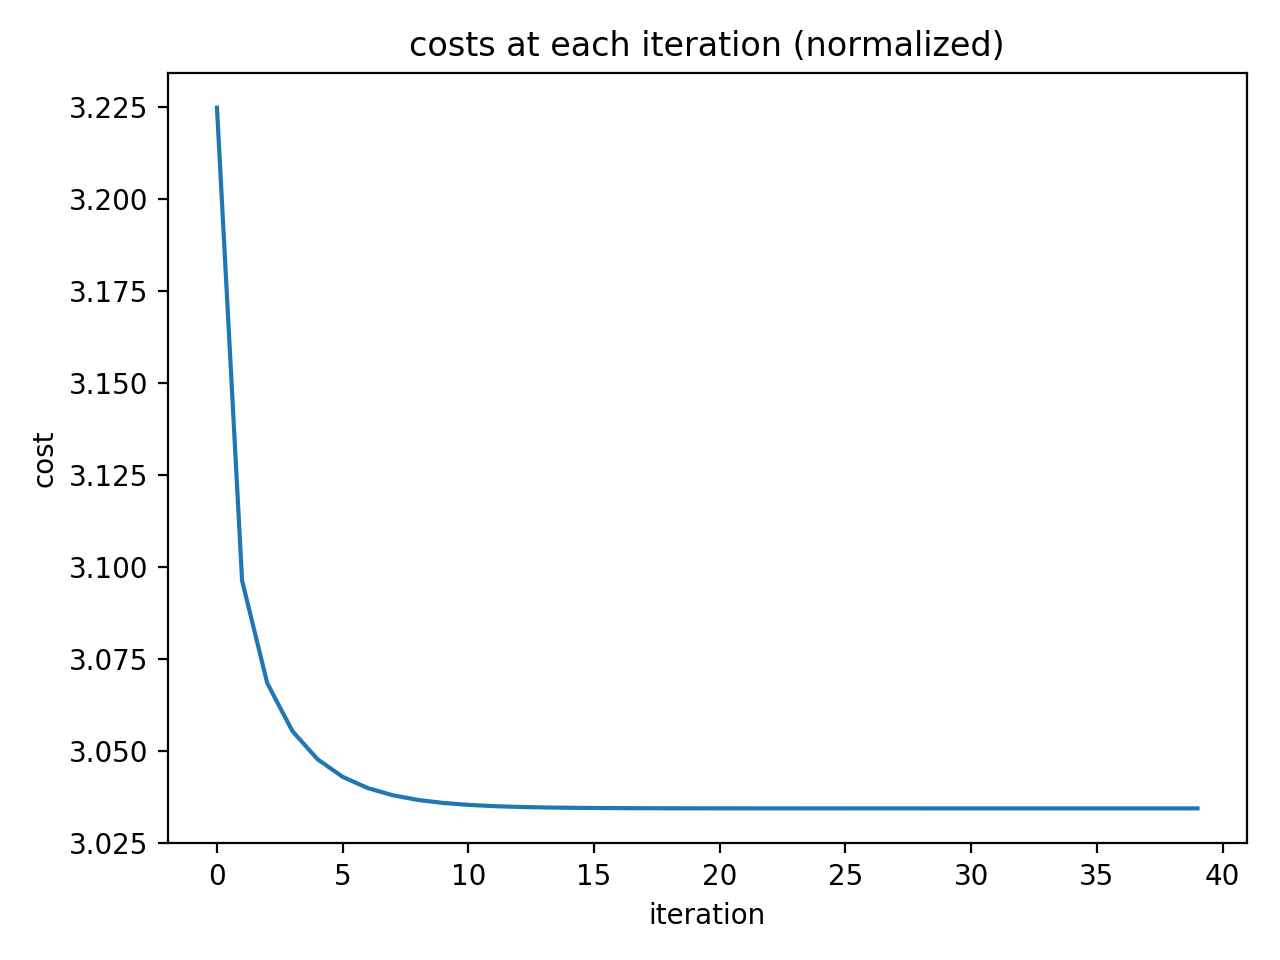

In [119]:
epsilon= 10**1
max_its=40
least_squares = lambda w: np.sum((predict(normed_X, w) - normed_Y)**2)
w_history = newtons_method(least_squares,w_init,max_its, epsilon)
iters = range(max_its)
costs = [least_squares(w) for w in w_history]
fig2 = plt.figure()
plt.plot(iters, costs)
plt.title('costs at each iteration (normalized)')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

# Conclusion

In this project, Newton's method outperforms gradient descent. The reason is that there are only 5 input features and the simple linear regression model is a convex function. When the objective function is convex, and the dimension of feature vector space is low, Newton's method optimizer will find the global optimum very quickly, usually in less than 30 steps. Ihe experiment also indicates that Newton's method is insensitive to feature scaling, and gradient descent is very sensitive to that. Feature normalization is a must before optimization with gradient descent.